In [1]:
import pandas as pd
import numpy as np
import statistics

from datetime import datetime

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn import set_config

import matplotlib.pyplot as plt

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({'font.size': 14})

%matplotlib inline

set_config(display='diagram')

In [2]:
df_all = pd.read_csv('../data/processed/0.3-feature-processing.csv', parse_dates=['date'], index_col=0)
df = df_all[df_all['year'] > 1959]
df = df.sort_values(by=['date']).reset_index(drop=True)
df = df.set_index('driverRef', append=True)
df = df.set_index('finished', append=True)

In [3]:
#The dates of the last 5 races of Season 2021
race_rounds_dates = {
    18: datetime(2021,11,7),
    19: datetime(2021,11,14),
    20: datetime(2021,11,21),
    21: datetime(2021,12,5),
    22: datetime(2021,12,12),
}

#Return Train/test split based on a race date (exclusive)
def splitByRaceDate(race_date):
    df_train = df.loc[df['date'] < race_date]
    df_test = df.loc[df['date'] >= race_date]

    X_train = df_train[df_train.columns.difference(['positionOrder', 'date', 'round', 'year'])]
    X_test = df_test[df_test.columns.difference(['positionOrder'])]

    y_train = df_train['positionOrder']
    y_test = df_test[['positionOrder','round']]

    return X_train, X_test, y_train, y_test

**Split train and test data for cross-validation**

In [4]:
X_train, X_test, y_train, y_test = splitByRaceDate(race_rounds_dates[18])

In [5]:
num_cols = len(X_train.columns) -1

In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_features_df = X_train.select_dtypes(include=numerics)

In [7]:
numeric_features = list(numeric_features_df.columns)

**Make costume scoring function**

In [8]:
def mseScorer(y_true, y_pred):
    y_rank = pd.DataFrame(y_pred).rank(method='first')
    return mean_squared_error(y_true=y_true, y_pred=y_rank)
    
mse_scorer = make_scorer(mseScorer, greater_is_better=False)

In [9]:
def noRetirementsScorer(y_true, y_pred):
    y_true = y_true.reset_index()
    y_rank = pd.DataFrame(y_pred).rank(method='first')
    y_concat = pd.concat([y_true, y_rank], axis=1)
    #print(y_concat.head(20))
    y_concat = y_concat[y_concat['finished'] == True]
    y_final = y_concat.iloc[:,-2:]
    y_final['rank_pred'] = y_final[y_final.columns[1]].rank(method='first')
    return mean_squared_error(y_true=y_final['positionOrder'], y_pred=y_final['rank_pred'])

no_retirements_scorer = make_scorer(noRetirementsScorer, greater_is_better=False)

In [10]:
def gridstartScorer(y_true, y_pred):
    y_concat = pd.concat([y_pred, y_true], axis=1, ignore_index=True)
    y_concat = y_concat.rename(columns={0:'y_pred',1:'y_true'})
    y_concat = y_concat.reset_index(level='finished')
    y_concat = y_concat[y_concat.finished == True]
    y_concat['pred_rank'] = y_concat['y_pred'].rank(method='first')
    return mean_squared_error(y_true=y_concat['y_true'],y_pred=y_concat['pred_rank'])

**Make timeseries cross-validation split, where each split consists of 20 drivers = 1 race**

In [11]:
tscv = TimeSeriesSplit(n_splits=55, test_size=20)

In [12]:
def calculateGridstartScore(tscv):
    mse_scores = []
    for _, test_index in tscv.split(X_train):
        X_test_cv = X_train.iloc[test_index]
        y_test_cv = y_train.iloc[test_index]
        score = gridstartScorer(y_test_cv, X_test_cv['gridStart'])
        mse_scores.append(score)

    return (statistics.mean(mse_scores), mse_scores)

**Calculate the score for the baseline model over the cross-validation races**

In [13]:
mean_mse_scores, mse_scores = calculateGridstartScore(tscv)
print('Gridstart baseline score: ', mean_mse_scores)

Gridstart baseline score:  12.421248816542935


In [14]:
def gridSearchCV_results(X_train, y_train, cv, scorer, pipeline, param_grid, output):
    model = GridSearchCV(
        estimator = pipeline,
        param_grid = param_grid,
        cv=cv,
        n_jobs=-1,
        scoring=scorer,
        verbose=1
    )
    model.fit(X_train,y_train)
    if output:
        print('Best parameters:\n', model.best_params_)
        print('Best mean accuracy score in cross-validation:\n', abs(model.best_score_))
    return model.best_estimator_, model.cv_results_

**Ridge regression**

In [15]:
trans = ColumnTransformer(
    [('one_hot', OneHotEncoder(drop=None, handle_unknown='ignore'), ['circuitName']),
    ('k_best',  SelectKBest(f_regression), numeric_features)]
    )

In [16]:
num_cols = len(X_train.columns) -1
ridge_pipeline = Pipeline([
    ('col_trans', trans),
    ('model', Ridge(random_state=42))
])
ridge_param_grid = {
    'col_trans__k_best__k': range(1,num_cols,2),
    'model__alpha':[0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1],
}
#pipeline.get_params()

In [17]:
ridgeRegression_model, ridge_cv_results = gridSearchCV_results(X_train, y_train, tscv, no_retirements_scorer, ridge_pipeline, ridge_param_grid, output=True)

Fitting 55 folds for each of 120 candidates, totalling 6600 fits
Best parameters:
 {'col_trans__k_best__k': 13, 'model__alpha': 0.001}
Best mean accuracy score in cross-validation:
 11.269621324667762


In [18]:
ridge_cv_results_df = pd.DataFrame(ridge_cv_results)
best_score_cv = ridge_cv_results_df.loc[ridge_cv_results_df['rank_test_score'] == 1]

best_score_cv = best_score_cv.head(1)

best_score_cv_array = best_score_cv.iloc[:,7:-3].values

In [19]:
# ridge_cv_results_df.loc[ridge_cv_results_df['rank_test_score'] == 1]

In [20]:
number_k_best_features = int(best_score_cv['param_col_trans__k_best__k'])
select = SelectKBest(f_regression, k = number_k_best_features)
z = select.fit_transform(X_train[numeric_features], y_train)

filter = select.get_support()
features = np.array(X_train[numeric_features].columns)
 
print("All features:")
print(features)
 
print("Selected best " + str(number_k_best_features) + ":")
print(features[filter])

All features:
['ageAtDebut' 'ageAtRace' 'constructorStandingsPosition'
 'constructorStandingsWins' 'driverStandingsPosition'
 'driverStandingsWins' 'gridStart' 'lastRaceRank' 'percentRetired'
 'percentageOfBestQuali' 'polePositions' 'posGainedLastRace'
 'previousRaceGridStart' 'previousRacePosition' 'racesFinished'
 'racesRetired' 'racesRetiredByConstructor' 'racesWon'
 'racesWonByConstructor' 'racingAtHome' 'yearsExperience']
Selected best 13:
['ageAtDebut' 'constructorStandingsPosition' 'constructorStandingsWins'
 'driverStandingsPosition' 'driverStandingsWins' 'gridStart'
 'polePositions' 'previousRacePosition' 'racesFinished'
 'racesRetiredByConstructor' 'racesWon' 'racesWonByConstructor'
 'yearsExperience']


In [21]:
x = np.absolute(best_score_cv_array)
y = list(x.flatten())

**Get statistics for validation set for best model and baseline**

In [22]:
print('Model cv mean: ', round(np.mean(y),2))
print('Model cv std: ', round(np.std(y),2))

print('Baseline cv mean: ', round(np.mean(mse_scores),2))
print('Baseline cv std: ', round(np.std(mse_scores),2))

Model cv mean:  11.27
Model cv std:  7.98
Baseline cv mean:  12.42
Baseline cv std:  9.01


**Plot model and baseline error across races in the validation set**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


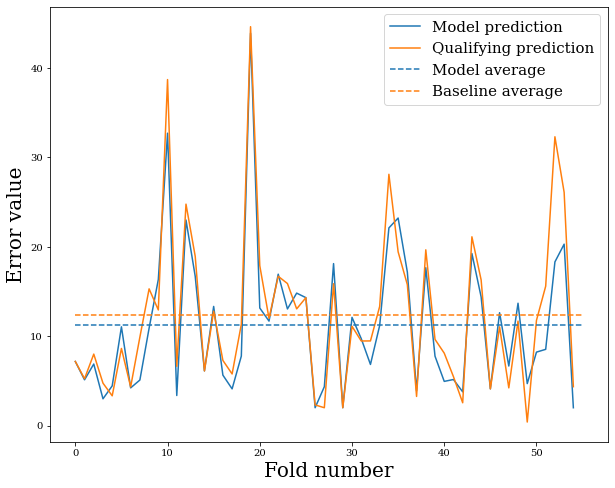

In [23]:
fig, ax = plt.subplots()

fig.set_size_inches(10, 8)

ax.plot(y, label='Model prediction')
ax.plot(mse_scores, label='Qualifying prediction')

ax.hlines(np.mean(y), xmin = 0, xmax= 55, colors='tab:blue', linestyles='dashed', label='Model average')
ax.hlines(np.mean(mse_scores), xmin = 0, xmax= 55, colors='tab:orange', linestyles='dashed', label='Baseline average')

plt.xlabel('Fold number', fontsize=20)
plt.ylabel('Error value', fontsize=20)

plt.legend(loc="upper right", prop={'size': 15})


plt.savefig("../reports/figures/cv_results" + ".eps")

### Random Forest regressor

In [24]:
# random_forest_pipeline = Pipeline([
#     ('one_hot', one_hot_encoder),
#     ('scaler', StandardScaler()),
#     ('model', RandomForestRegressor(random_state=42))
# ])

# random_forest_param_grid = {
#     'scaler':['passthrough', StandardScaler(with_mean=False)],
#     'model__max_depth':[5,8,10,None],
#     'model__min_samples_split':[2,3,4],
#     'model__min_samples_leaf': [2,3,4],
#     'model__n_estimators':[200],
#     'model__max_features':['auto'],
# },

# random_forest_model = gridSearchCV_results(X_train, y_train, tscv, no_retirements_scorer, random_forest_pipeline, random_forest_param_grid, output=True)

**Test on 5 last races of 2021 season**

In [25]:
def createResultsTable(X_test, y_pred, y_test, round):
    X_test = X_test.reset_index()
    # X_test = X_test.reset_index(level=['finished'])
    #X_test = X_test.reset_index(drop=True)

    df_results = pd.concat([X_test[['driverRef','finished','gridStart']], pd.DataFrame(y_pred, columns=['y_pred'])], axis=1)

    df_results['rank_pred'] = df_results['y_pred'].rank(method='first').astype(int)
    df_results = df_results.drop('y_pred', axis=1)

    y_test = y_test.reset_index(level=['driverRef'])

    final_result = pd.merge(df_results, y_test[['driverRef','positionOrder']], on=['driverRef'])
    final_result = final_result.rename(columns={'positionOrder':'rank_true'})
    #final_result['y_pred'] = final_result['y_pred'].round(2)

    final_result = final_result.sort_values(by=['gridStart'])
    final_result['round'] = round
    return final_result

In [26]:
df_every_round_results = pd.DataFrame()
test_results = []

model = ridgeRegression_model

for round, date in race_rounds_dates.items():
    X_train, X_test, y_train, y_test = splitByRaceDate(date)
    model.fit(X_train, y_train)
    
    X_test_current_round = X_test.loc[X_test['round'] == round]
    y_pred_current_round = model.predict(X_test_current_round)
    y_test_current_round = y_test.loc[y_test['round'] == round]

    df_results = createResultsTable(X_test_current_round, y_pred_current_round, y_test_current_round, round)
    df_every_round_results = df_every_round_results.append(df_results)

    model_mse = noRetirementsScorer(y_true=y_test_current_round.iloc[:,:-1], y_pred=y_pred_current_round)
    grid_start_mse = noRetirementsScorer(y_true=y_test_current_round.iloc[:,:-1], y_pred=X_test_current_round['gridStart'].to_numpy())
    #model_mse =  noRetirementsScorer(y_true=df_results['rank_true'], y_pred=df_results['rank_pred'])
    #grid_start_mse = noRetirementsScorer(y_true=df_results['rank_true'], y_pred=df_results['gridStart'])

    test_results.append([round, model_mse, grid_start_mse])

test_results = pd.DataFrame(test_results, columns=['round', 'model_error', 'baseline_error'])

In [27]:
test_results

,round,model_error,baseline_error
0,18,17.111111,19.666667
1,19,4.444444,10.222222
2,20,10.111111,14.555556
3,21,12.533333,12.000000
4,22,19.375000,15.875000


In [28]:
df_every_round_results.reset_index(drop=True)

,driverRef,finished,gridStart,rank_pred,rank_true,round
0,bottas,True,1,3,15,18
1,hamilton,True,2,1,2,18
2,max_verstappen,True,3,2,1,18
3,perez,True,4,4,3,18
4,gasly,True,5,9,4,18
...,...,...,...,...,...,...
95,latifi,False,16,17,16,22
96,russell,False,17,18,18,22
97,raikkonen,False,18,15,19,22
98,mick_schumacher,True,19,19,14,22


In [29]:
df_every_round_results.to_csv('../data/processed/0.4-test_results.csv', index=False)